# MNIST Digit Classification

## 1) Imports + Setup

We'll set:
- a **seed** for reproducibility
- a **device** (`cuda` if available)

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import matplotlib.pyplot as plt

torch.manual_seed(42)


In [2]:
torch.cuda.is_available()

False

In [3]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## 2) MNIST

MNIST is a dataset of **28×28 grayscale images** of handwritten digits (0–9).

Each example:
- image: a single-channel image of shape `(1, 28, 28)` after `ToTensor()`
- label: an integer in `{0,1,2,...,9}`

## 3) Transforms: `Compose`, `ToTensor`, `Normalize`

### Why do we need transforms?
Raw images from datasets are often **PIL images** (not tensors). Neural networks train on tensors.

### `transforms.ToTensor()`
Converts a PIL image to a `torch.FloatTensor` and:
- changes shape from `(H, W)` to `(C, H, W)` → MNIST becomes `(1, 28, 28)`
- scales pixel values from **0–255** to **0–1**

### `transforms.Normalize(mean, std)`
After converting to tensor, normalization does:
\[
x \leftarrow \frac{x - \mu}{\sigma}
\]
This helps training converge more smoothly.

### `transforms.Compose([...])`
A pipeline that applies multiple transforms in order, e.g.
1. `ToTensor()`
2. `Normalize(...)`

### 3.1 Load a raw MNIST sample (no transform) and inspect it
Here we deliberately set `transform=None` so we can see what the dataset returns **before** transforms.

In [4]:
raw_train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=None)

img_pil, label = raw_train_ds[0]
type(img_pil), label

100%|██████████| 9.91M/9.91M [00:00<00:00, 132MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 22.0MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 106MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.85MB/s]


(PIL.Image.Image, 5)

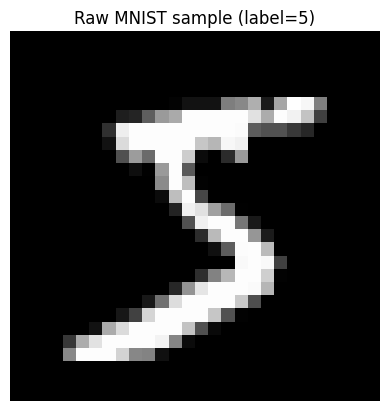

In [5]:
# Let's display the PIL image
plt.figure()
plt.imshow(img_pil, cmap="gray")
plt.title(f"Raw MNIST sample (label={label})")
plt.axis("off")
plt.show()

### 3.2 `ToTensor()` example

Notice:
- type changes to `torch.Tensor`
- shape becomes `(1, 28, 28)`
- dtype becomes `torch.float32`
- values are in `[0, 1]`

In [6]:
to_tensor = transforms.ToTensor()

img_tensor = to_tensor(img_pil)
print("type:", type(img_tensor))
print("shape:", img_tensor.shape)
print("dtype:", img_tensor.dtype)
print("min/max:", img_tensor.min().item(), img_tensor.max().item())

type: <class 'torch.Tensor'>
shape: torch.Size([1, 28, 28])
dtype: torch.float32
min/max: 0.0 1.0


### 3.3 `Normalize()` example (with `Compose`)

We will use common MNIST normalization constants:
- mean = 0.1307
- std  = 0.3081

After normalization, values are no longer constrained to `[0, 1]`.

In [7]:

sum_ = 0.0
sum_sq = 0.0
count = 0

for img, _ in raw_train_ds:
    x = transforms.ToTensor()(img)  # shape: [1, 28, 28], values: 0..1
    sum_ += x.sum().item()
    sum_sq += (x * x).sum().item()
    count += x.numel()

mean = sum_ / count
var = (sum_sq / count) - (mean ** 2)
std = var ** 0.5

mean, std

(0.13066047797803165, 0.3081078048756658)

In [8]:
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

img_norm = mnist_transform(img_pil)

print("shape:", img_norm.shape)
print("dtype:", img_norm.dtype)
print("min/max:", img_norm.min().item(), img_norm.max().item())
print("mean/std:", img_norm.mean().item(), img_norm.std().item())

shape: torch.Size([1, 28, 28])
dtype: torch.float32
min/max: -0.4242129623889923 2.821486711502075
mean/std: 0.022655218839645386 1.01443612575531


## 4) `DataLoader`
A `DataLoader` wraps a dataset and gives:
- **mini-batches** of size `batch_size`
- optional **shuffling** (`shuffle=True`)
- faster loading via `num_workers`

In training, we almost always iterate over a **DataLoader**.

### 4.1 Build train/test datasets with transforms

In [9]:
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=mnist_transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=mnist_transform)

print("Train size:", len(train_ds))
print("Test size :", len(test_ds))

Train size: 60000
Test size : 10000


### 4.2 Inspect one transformed sample

In [10]:
x, y = train_ds[0]
print("x shape:", x.shape)     # (1, 28, 28)
print("y:", y)                 # integer label
print("x dtype:", x.dtype)

x shape: torch.Size([1, 28, 28])
y: 5
x dtype: torch.float32


### 4.3 Create DataLoaders and inspect a batch

The `DataLoader` returns:
- `images`: shape `(B, 1, 28, 28)`
- `labels`: shape `(B,)`

We'll use:
- `batch_size=128`
- `shuffle=True` for training

In [11]:
BATCH_SIZE = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

images, labels = next(iter(train_loader))
print("batch images:", images.shape)
print("batch labels:", labels.shape)
print("labels (first 10):", labels[:10].tolist())

batch images: torch.Size([128, 1, 28, 28])
batch labels: torch.Size([128])
labels (first 10): [1, 2, 8, 5, 2, 6, 9, 9, 9, 4]


## 5) Building the model using **only** `nn.Sequential`

We will build a **Multi-Layer Perceptron (MLP)**.

### Key layers
#### `nn.Flatten()`
MNIST images come as `(B, 1, 28, 28)`.  
A fully-connected layer (`nn.Linear`) expects `(B, features)`.

`Flatten` converts:
- `(B, 1, 28, 28)` → `(B, 784)`

#### `nn.Dropout(p)`
Dropout randomly **zeros out** a fraction `p` of activations **during training**.
- Helps reduce overfitting
- During evaluation (`model.eval()`), dropout is disabled

We'll include Dropout after ReLU.

### 5.1 `Flatten` example (shape change)

In [12]:
toy = torch.randn(2, 1, 28, 28)
flat = nn.Flatten()

toy_flat = flat(toy)
print("before:", toy.shape)
print("after :", toy_flat.shape)

before: torch.Size([2, 1, 28, 28])
after : torch.Size([2, 784])


### 5.2 `Dropout` example (train vs eval)

In [20]:
drop = nn.Dropout(p=0.2)
x = torch.ones(10)

drop.train()
out_train_1 = drop(x)  # Drop and mul with 1/(1-p)
out_train_2 = drop(x)  # Drop and mul with 1/(1-p)

drop.eval()
out_eval_1 = drop(x)
out_eval_2 = drop(x)

print("Input:", x)
print("\nTrain mode outputs (different each call):")
print(out_train_1)
print(out_train_2)

print("\nEval mode outputs (dropout off, identical):")
print(out_eval_1)
print(out_eval_2)

Input: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Train mode outputs (different each call):
tensor([1.2500, 1.2500, 0.0000, 1.2500, 1.2500, 0.0000, 1.2500, 1.2500, 1.2500,
        1.2500])
tensor([1.2500, 1.2500, 1.2500, 1.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.2500])

Eval mode outputs (dropout off, identical):
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


### 5.3 Define the MLP

Architecture:
- Flatten
- Linear(784 → 256) + ReLU + Dropout
- Linear(256 → 128) + ReLU + Dropout
- Linear(128 → 10)

**Note:** The final layer outputs **logits** (raw scores).  
We do **NOT** add `Softmax` because `CrossEntropyLoss` expects logits.

In [14]:
DROPOUT_P = 0.2

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 256),
    nn.ReLU(),
    nn.Dropout(DROPOUT_P),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(DROPOUT_P),

    nn.Linear(128, 10)
).to(device)

model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=256, out_features=128, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): Linear(in_features=128, out_features=10, bias=True)
)

## 6) Loss + Optimizer

### `CrossEntropyLoss`
For multi-class classification. It combines:
- `log_softmax`
- `nll_loss`

### `Adam` + `weight_decay`
`weight_decay` implements **L2 regularization** (a gentle penalty on large weights).
It often helps generalization.

We'll start with:
- `lr = 1e-3`
- `weight_decay = 1e-4`

In [15]:
criterion = nn.CrossEntropyLoss()

LR = 1e-3
WEIGHT_DECAY = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

criterion, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0.0001
 ))

## 7) Training loop (the standard PyTorch pattern)

For each batch:
1. `optimizer.zero_grad()` — clear old gradients
2. `logits = model(x)` — forward pass
3. `loss = criterion(logits, y)` — compute loss
4. `loss.backward()` — compute gradients (autograd)
5. `optimizer.step()` — update parameters

We'll track:
- average training loss
- training accuracy
- test accuracy

In [16]:
def compute_accuracy(loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
    
            logits = model(x)
            preds = logits.argmax(dim=1)
    
            correct += (preds == y).sum().item()
            total += y.size(0)

    return correct / total


def train_one_epoch(loader):
    model.train()
    loss_sum = 0.0
    correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return loss_sum / len(loader), correct / total

### 7.1 Train for a few epochs

You should see test accuracy climb quickly (often ~97–98% for this simple MLP).

In [17]:
EPOCHS = 5

history = {"train_loss": [], "train_acc": [], "test_acc": []}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(train_loader)
    test_acc = compute_accuracy(test_loader)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["test_acc"].append(test_acc)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | test_acc={test_acc:.4f}")

Epoch 01 | train_loss=0.3113 | train_acc=0.9058 | test_acc=0.9603
Epoch 02 | train_loss=0.1345 | train_acc=0.9590 | test_acc=0.9726
Epoch 03 | train_loss=0.1002 | train_acc=0.9688 | test_acc=0.9740
Epoch 04 | train_loss=0.0849 | train_acc=0.9735 | test_acc=0.9765
Epoch 05 | train_loss=0.0729 | train_acc=0.9768 | test_acc=0.9795


## 8) Plot training curves (loss/accuracy)

This helps learners see:
- loss trending down
- accuracy trending up

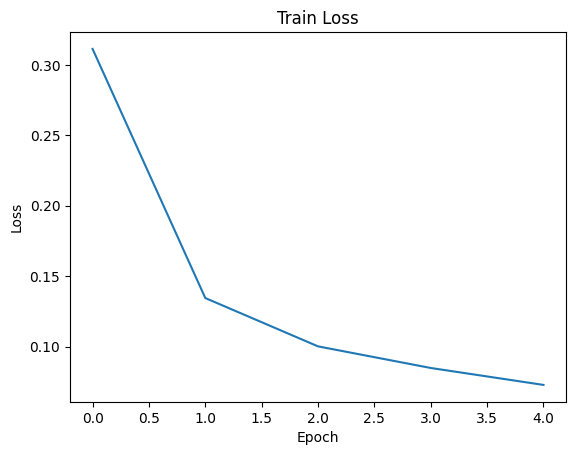

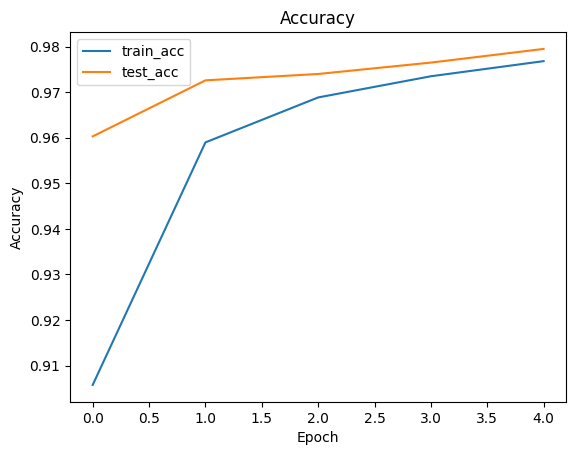

In [18]:
plt.figure()
plt.plot(history["train_loss"])
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 9) (Optional) Visualize predictions

We'll show a small grid of test images with:
- predicted label
- true label

This is great to end a training session because it connects metrics back to real examples.

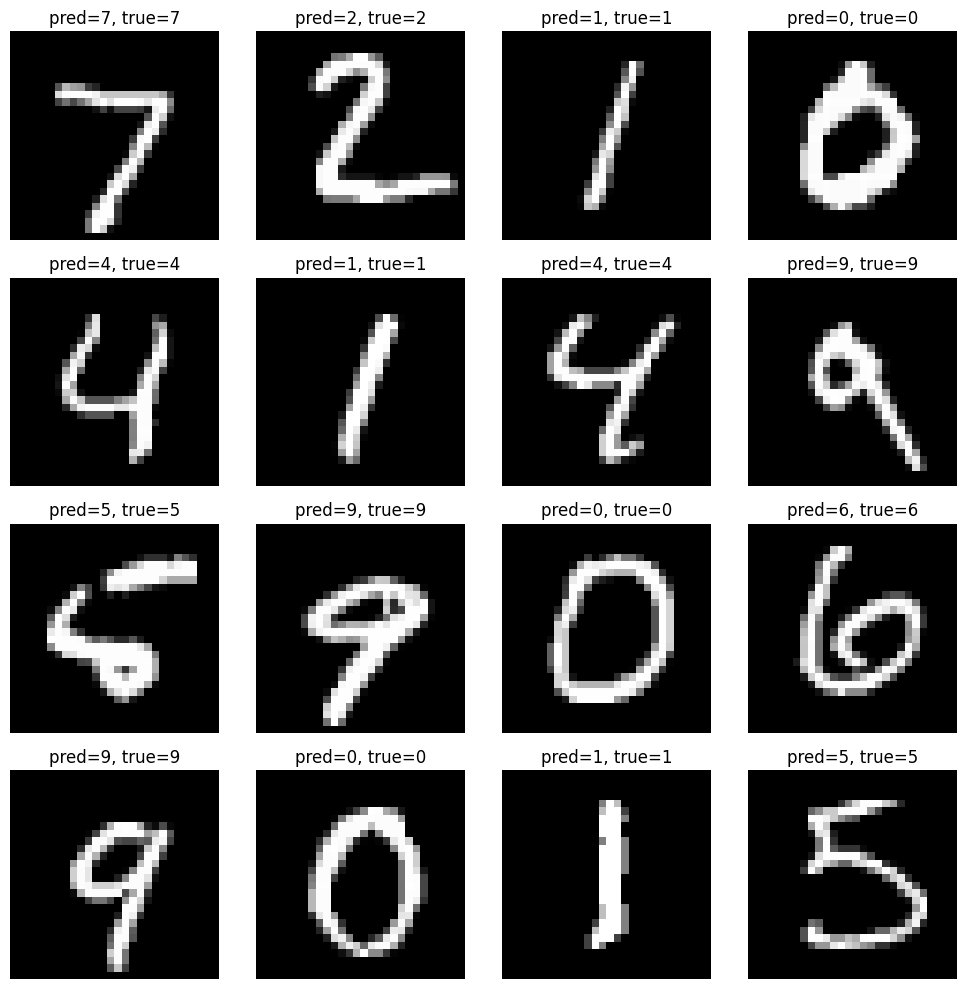

In [19]:
@torch.no_grad()
def show_predictions(n=16):
    model.eval()
    x, y = next(iter(test_loader))
    x = x.to(device)
    y = y.to(device)

    logits = model(x)
    preds = logits.argmax(dim=1)

    x_cpu = x.cpu()
    y_cpu = y.cpu()
    preds_cpu = preds.cpu()

    n = min(n, x_cpu.size(0))
    cols = 4
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(10, 2.5 * rows))
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(x_cpu[i].squeeze(0), cmap="gray")
        plt.title(f"pred={preds_cpu[i].item()}, true={y_cpu[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(16)